In [1]:
import cv2
import os
import numpy as np
import dask as d
import gudhi as gd
import networkx as nx
import matplotlib.pyplot as plt
from pydmtgraph.helper import plotGraph

from glob import glob
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance

In [2]:
import fl_tissue_model_tools.topology as topo
import fl_tissue_model_tools.preprocessing as prep
from fl_tissue_model_tools import defs, dev_config, data_prep

In [3]:
def load_img(img_name, dsamp=True, dsize=250):
    '''
        Load the image {img_name} and downsample if {dsamp}
    '''
    # cv.IMREAD_ANYDEPTH loads the image as a 16 bit grayscale image
    img = cv2.imread(img_name, cv2.IMREAD_ANYDEPTH)
    if dsamp:
        return cv2.resize(img, dsize, cv2.INTER_AREA)
    else:
        return img


def load_and_norm(img_name, a, b, mn, mx, dsamp=True, dsize=250):
    '''
        Load the image {img_name},
        normalize the image from the range [{mn}, {mx}] to the range [{a}, {b}],
        and downsample the image to size {dsize}x{dsize} if {dsamp}
    '''
    img = load_img(img_name, dsamp=True, dsize=dsize)
    return prep.min_max_(img, a, b, mn, mx)


def mask_and_threshold(img, circ_mask, pinhole_idx, sd_coef, rs):
    '''
        Apply the circle mask {circ_mask} to the image {img}
        and then perform foreground thresholding on the masked image
    '''
    masked = prep.apply_mask(img, circ_mask).astype(float)
    return prep.exec_threshold(masked, pinhole_idx, sd_coef, rs)


In [4]:
dirs = dev_config.get_dev_directories("../../dev_paths.txt")

In [5]:
cell_data_dir = f"{dirs.data_dir}/cell_topology/PACLITAXEL/POST_DRUG/CASKI/"
figure_output_dir = f"{dirs.figures_dir}/cell_topology/2022_03_30_PACLITAXEL/POST_DRUG/CASKI/"
# Create output directory for analysis figure visualizations
data_prep.make_dir(figure_output_dir)

In [6]:
dsamp_size = 500 # side length of downsampled image 
pinhole_cut = 10 # the radius of the circle mask is ({dsamp_size}//2 -  {pinhole_cut})
sd_coef = -1 # threshold takes all pixels {sd_coefs} standard deviations away from the mean of the foreground Gaussian

In [7]:
img_names = [img.replace("\\", "/") for img in glob(f"{cell_data_dir}/*.tif")]

In [8]:
gs_ds_imgs = d.compute(
    # [d.delayed(load_and_norm)(img_n, gs_min, gs_max, tif_min, tif_max, dsamp=True, dsize=(dsamp_size, dsamp_size)) for img_n in img_names]
    [d.delayed(load_and_norm)(img_n, defs.GS_MIN, defs.GS_MAX, defs.TIF_MIN, defs.TIF_MAX, dsamp=True, dsize=(dsamp_size, dsamp_size)) for img_n in img_names]
)[0]

In [9]:
# variables for image masking
img_shape = gs_ds_imgs[0].shape
img_center = (img_shape[0] // 2, img_shape[1] // 2)
circ_rad = img_center[0] - (pinhole_cut)
circ_mask = prep.gen_circ_mask(img_center, circ_rad, img_shape, defs.GS_MAX)
pinhole_idx = np.where(circ_mask > 0)
circ_pix_area = np.sum(circ_mask > 0)

In [10]:
# apply the circle mask to all images and then 
# foreground threshold the image
rs_all = np.random.RandomState(seed=123)
thresh_masked_all = d.compute(
    [d.delayed(mask_and_threshold)(img, circ_mask, pinhole_idx, sd_coef, rs_all)
     for img in gs_ds_imgs]
)[0]


In [11]:
# Apply the distance transform to threshold image 
# and the blur the distance-transformed image
dt_thresh_masked_all = d.compute(
    [d.delayed(prep.dt_blur)(img, 7) for img in thresh_masked_all] 
)[0]


In [12]:
# apply a second binary threshold to the image, 
# this time taking all pixels with value >0
# in effect, dting, bluring, and rethresholding
# just expands each connected components, potentially connecting some
gs_bin_thresh_masked_all = d.compute(
    [d.delayed(prep.bin_thresh)(img, defs.GS_MAX) for img in dt_thresh_masked_all]
)[0]

In [13]:
# blur every image
gs_blur_all = d.compute(
    [d.delayed(prep.blur)(img, blur_itr=7) for img in thresh_masked_all]
)[0]

In [14]:
# good network indices: CASKI: 28, 32, 41, 61, 22, 26
#                       HMVEC: 28, 15, 20
# unclear network indices: CASKI: 3, 41, 1 (blurred), 
#                          HMVEC: 40, 48, 6
img_idx = 22
im_og = gs_ds_imgs[img_idx]
im_blur = gs_blur_all[img_idx]
mask = gs_bin_thresh_masked_all[img_idx]

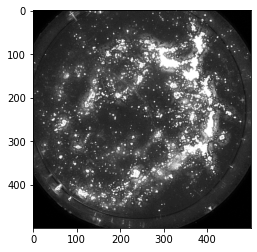

In [15]:
plt.imshow(im_og, cmap="gray")
plt.show()

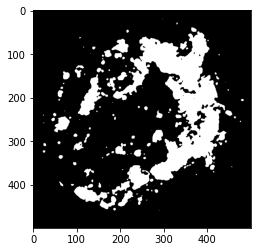

In [16]:
plt.imshow(mask, cmap="gray")
plt.show()

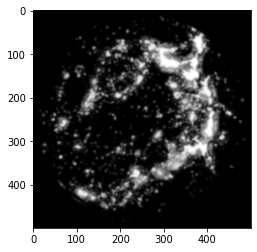

In [17]:
plt.imshow(im_blur, cmap='gray')
plt.show()

In [20]:
verts, edges, bc = topo.__compute_morse_skeleton_and_barcode_one_component(im_blur / 255, 0.6, 0.1)

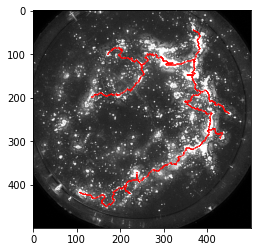

1945


In [21]:
fig, ax = plt.subplots()

# add the original image to the plot
ax.imshow(im_og, cmap='gray')

# if the graph is not empty, add it to the plot
if (len(edges) > 0):
    plotGraph(verts , edges, ax)
else:
    print("No graph found")
    
plt.show()
print(len(verts))

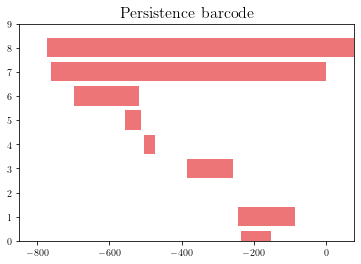

In [22]:
# if the barcode is not empty, plot it!
if (len(bc)>0):
    gd.plot_persistence_barcode(bc)
    plt.show()